In [398]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [399]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import math

import matplotlib.pyplot as plt

# Part 1: Naïve Bayes Classification


---
**Instructions:**<br>
You are given a training dataset in CSV format (hw5_naive.csv). The training data has
5,600 rows:
- Columns 1 through 6 of the given CSV file represent the features (X)
- The last column (“Label”) represents the class label (Y) (0 or 1)



**1.a:** Divide the data into train / test sets (80% and 20% respectively)

In [400]:
# Reading the data:
naive_train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/hw5_naive.csv')
print(naive_train_data.head)

# Defining x and y:
y = naive_train_data['Label']  # y defines the "target"/labels
x = naive_train_data[['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6']]  # x defines the features

# Following advice from TA -- extract Feature_3 and reshape for MinMaxScaler (to eliminate negative values)
feature_3 = x['Feature_3'].values.reshape(-1, 1)

# Initialize and apply MinMaxScaler to Feature_3
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_feature_3 = scaler.fit_transform(feature_3)

# Replace the original Feature_3 in the dataset with the scaled version
x.loc[:, 'Feature_3'] = scaled_feature_3

# Split into trains and tests:
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.2, random_state=74380)

<bound method NDFrame.head of       Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  Label
0       7430.14    9529.78   -2453.33         19        123        621      0
1      11256.40   50455.10   -4220.00         18        216       2677      0
2      13093.00   51897.10   -2880.00         30        234       2464      0
3      14303.00  102632.00   -5702.20        144        281       4061      1
4      14688.00   83343.40   -2430.00         52        223       2822      1
...         ...        ...        ...        ...        ...        ...    ...
5595   10424.80   35041.40   -4345.67        114        208       1691      0
5596    5976.87   10806.00   -2662.00          3         98        654      1
5597   15793.50  216990.00   -9819.00         44        338       8323      1
5598    8787.16   20778.60   -3470.08         92        163       1162      0
5599    8322.40   12208.90   -2592.59         83        128        693      0

[5600 rows x 7 columns]>


**1.b:** Implement a Multinomial Naïve Bayes classifier from scratch, with smoothing. You can set the default smoothing value to 1. You are free to code this up however you like, however, make sure that there is a function that can be called with a test X vector and returns the predicted Y.
<br><br>
**NOTES FROM LECTURE 11 SLIDES**:<br>
-Naive Bayes states; P(C|X) = (P(X|C) * P(C)) / P(X)

-Max a Posterior (MAP) Rule: (P(X|C) * P(C)) / P(X) ~= (P(X|C) * P(C)) --> C* = argmaxci(P(X1, . . . , Xn|Ci) * P(Ci))

-Use log addition instead of multiplication to prevent floating point errors --> C* = argmaxci(n∑j=1(log(P(Xj|Ci)) + log(P(Ci))))

-For notation purposes, P(Xj|Ci) = P(Xi = v|c)

-Smoothing: P(Xi = v|c) = (Count(Xi = v & class = c) + 1) / (Count(class = c) + k)

-From TA: Use medical table example in slides to see how to write the algorithm

In [401]:
# First define the function, fit, that trains by the model by assessing counts within the data -- return the learned parameters

# Based of medical example from Lecture 11 slides:
def multinomial_fit(train_x,train_y):
  # Convert into numpy array for easier data analysis:
  samples = np.array(train_x)
  labels = np.array(train_y)

  classes = np.unique(labels)  # Stores the class labels in an array
  num_features = samples.shape[1]  # Indicates the number of features by counting the number of columns in the samples data

  feature_value_counts_by_class = {}  # Stores counts for each unique feature value per class
  priors = {}  # Stores the prior P(C) for each class

  for curr_class in classes:
    samples_by_class = samples[labels == curr_class]  # Array of rows where label only matches the current class
    priors[curr_class] = len(samples_by_class) / len(samples)  # Prior P(C) = # rows of data for a class / total rows of data

    # Create a nested dictionary for the current class to track individual feature values:
    feature_value_counts_by_class[curr_class] = {}

    # Find all unique values in each feature, and count occurances of each value for the current class:
    for feature_index in range(num_features):
      # features_by_class[:, feature_index] = of the rows where label only matches the current class, split into columns by their feature number (feature 1, feature 2, etc.)
      feature_values, counts = np.unique(samples_by_class[:, feature_index], return_counts=True)
      # Pair the unique values with their counts using zip
      feature_value_counts_by_class[curr_class][feature_index] = dict(zip(feature_values, counts))

  return classes, priors, feature_value_counts_by_class

In [402]:
# Now define the function, predict, which predicts class labels for the test data using the trained multinomial model from fit

def multinomial_predict(test_x, classes, priors, feature_value_counts_by_class, alpha):
  samples = np.array(test_x)

  y_predictions = []
  for sample in samples:
    posteriors = []  # Will ultimately be an array of two values -- the two probabilities of class 0 or 1

    # Store log probability (i.e. posterior) for each class
    for curr_class in classes:
      log_prior = np.log(priors[curr_class])
      log_likelihood = 0

      # Calculate total likelihood by adding likelihood of each feature value of each feature for a class
      for feature_index, feature_value in enumerate(sample):  # For each value in each feature:
        # Obtain the dictionary of individual values: count for each feature
        feature_value_counts = feature_value_counts_by_class[curr_class].get(feature_index, {})  # Use .get if a class does not have a specific feature value/prevent error throw
        count = feature_value_counts.get(feature_value, 0)
        total_count = sum(feature_value_counts.values())  # Same as len(samples_by_class) from .fit, = number of rows of data for a class

        # Likelihood formula with Laplace smoothing
        log_likelihood += np.log((count + alpha) / (total_count + len(classes)))

      posteriors.append(log_prior + log_likelihood)

    better_class_index = np.argmax(posteriors)  # Find the index (0 or 1) of the higher probability
    y_predictions.append(classes[better_class_index])

  return y_predictions

In [403]:
# Now test the model:

alpha = 1  # Define smoothing factor (default = 1)

# Fit the model to training data:
classes, priors, feature_value_counts_by_class = multinomial_fit(train_x, train_y)

# Predict on the test set:
multinomial_predictions = multinomial_predict(test_x, classes, priors, feature_value_counts_by_class, alpha)

# Evaluate the model using accuracy score
multinomial_accuracy = accuracy_score(test_y, multinomial_predictions)
multinomial_f1_macro = f1_score(test_y, multinomial_predictions, average='macro')

**1.c:** Implement a Gaussian Naïve Bayes classifier from scratch (no
need for smoothing here).
<br><br>
**NOTES FROM LECTURE 11 SLIDES**:<br>
-General implementation is the same as Multinomial, except now P(Xi = v|c) = 1/(2π(σc)^2) * e^−((v−μc)^2/(2(σc)^2))

-Now as a result, fit is modified to calculate means and variances of features instead of counts of features

In [404]:
# First define the function, fit, that trains by the model by assessing counts within the data -- return the learned parameters
def gaussian_fit(train_x,train_y):

  # Ensure conversion into numpy array to perform data analysis:
  samples = np.array(train_x)
  labels = np.array(train_y)

  classes = np.unique(labels)  # Stores the class labels in an array
  num_features = samples.shape[1]  # Indicates the number of features by counting the number of columns in the sample data

  # Initialize dictionaries to store parameters:
  means_by_class = {}
  variances_by_class = {}
  priors = {}

  # Loop through each class (0,1) and calculate data statistics
  for curr_class in classes:
    samples_by_class = samples[labels == curr_class]  # Array of rows where label only matches the current class

    # Calculate mean and variance for each feature:
    means_by_class[curr_class] = np.mean(samples_by_class, axis=0)  # axis=0 means sum the columns only
    variances_by_class[curr_class] = np.var(samples_by_class, axis=0)

    # Calculate prior probabilities P(C):
    priors[curr_class] = len(samples_by_class) / len(samples)

  return classes, priors, means_by_class, variances_by_class

In [405]:
# Now define the function, predict, which predicts class labels for the test data using the trained gaussian model from fit

def gaussian_predict(test_x, classes, priors, means_by_class, variances_by_class):
  samples = np.array(test_x)

  y_predictions = []
  for sample in samples:
    posteriors = []  # Will ultimately be an array of two values -- the two probabilities of class 0 or 1

    # Store log probability (i.e. posterior) for each class
    for curr_class in classes:
      log_prior = np.log(priors[curr_class])
      log_likelihood = 0

      # Calculate total likelihood by adding likelihood for each feature
      for feature_index, feature_value in enumerate(sample):
        feature_mean = means_by_class[curr_class][feature_index]
        feature_variance = variances_by_class[curr_class][feature_index]

        # Likelihood formula (Gaussian) -- in case variance is tiny, add a cap to prevent division by 0 error
        log_likelihood += np.log(max((1 / math.sqrt(2*math.pi*(feature_variance**2))) * np.exp((-(feature_value - feature_mean)**2) / (2*(feature_variance**2))), 1e-6))  # P(Xi = v|c)

      posteriors.append(log_prior + log_likelihood)

    better_class_index = np.argmax(posteriors)  # Find the index (0 or 1) of the higher probability
    y_predictions.append(classes[better_class_index])

  return y_predictions

In [406]:
# Now test the model:

# Fit the model to training data:
classes, priors, means_by_class, variances_by_class = gaussian_fit(train_x, train_y)

# Predict on the test set:
gaussian_predictions = gaussian_predict(test_x, classes, priors, means_by_class, variances_by_class)

# Evaluate the model using accuracy score
gaussian_accuracy = accuracy_score(test_y, gaussian_predictions)
gaussian_f1_macro = f1_score(test_y, gaussian_predictions, average='macro')

**1.d:** Calculate the accuracy and the F1 score of test data using both
of your models implemented above.

In [407]:
print("Multinomial NB model (from scratch) accuracy: ", multinomial_accuracy)
print("Multinomial NB model (from scratch) F1: ", multinomial_f1_macro)

print("\n")

print("Gaussian NB model (from scratch) accuracy: ", gaussian_accuracy)
print("Gaussian NB model (from scratch) F1: ", gaussian_f1_macro)

Multinomial NB model (from scratch) accuracy:  0.8776785714285714
Multinomial NB model (from scratch) F1:  0.8743982469452924


Gaussian NB model (from scratch) accuracy:  0.5785714285714286
Gaussian NB model (from scratch) F1:  0.5065047572104973


# Part 2: Clustering


---
**Instructions:**<br>
You are given a training dataset in CSV format (hw5_cluster.csv). The files each contain
40 rows with 2 columns. Column 1 & 2 are the features. There are no labels for this
dataset. Your goal for this assignment is to implement a clustering algorithm and run it
on this dataset. For this assignment you can the Euclidean distance as the distance
function.





**2.a:** Implement a generalized K-means algorithm from scratch. You
should have a single function that takes in as input the data points, K, and some
other hyperparameters, specified below. The function should return K sets of data
points. Each set corresponding to one cluster.

The hyperparameters your functions should support and the values they can take are:
- The method for calculating the centroid (i.e. the mean)
- The initialization method: Random Split Initialization or Random Seed
Selection Method
- Max_iter: max number of iterations to run the algorithm.
- K: number of clusters<br><br>
Note that your stopping condition should have two parts:
1. Stop if you reach the max iterations
2. Stop if no change is made to the clusters in the last step.

In [408]:
def k_means(data, init_method, max_iter, k, threshold):
  # Convert to numpy array for easier manipulation:
  data = np.array(data)
  vals = data.shape[0]

  # Following heuristic outlines from Lecture 15/help from TA office hours:

  if init_method == 'random_split':
    # Split S into an initial, randomized set of k buckets (i.e. clusters) (the buckets are prefilled with values from S)
    np.random.shuffle(data)
    clusters = np.array_split(data, k)  # use array_split instead of split in case bucket sizes are not equal
    cluster_centers = np.array([np.mean(cluster, axis=0) for cluster in clusters])  # Compute initial mean (i.e. cluster centers) of each bucket

  elif init_method == 'random_seed':
    # Create k empty buckets, and randomly select k distinct values (i.e. the "seed") from S to initialize each bucket (one seed per bucket)
    random_indices = np.random.choice(vals, k, replace=False)  # choose k values as "seeds" (without repeats)
    cluster_centers = data[random_indices]

  else:
    print("Invalid initialization method -- choose either 'random_split' or 'random_seed'")
    return

  # Repeat until a certain number of iterations are performed (or no change occurs/change is below a threshold):
  for iter in range(max_iter):
    new_clusters = [[] for num in range(k)]

    # For each data point in the data set, calculate the euclidian distance between the point and each cluster center:
    for s in data:
      distances = [np.linalg.norm(s - center) for center in cluster_centers]
      # Find the cluster Si such that distance is minimal and put the data point in that cluster:
      closest_cluster_index = np.argmin(distances)
      new_clusters[closest_cluster_index].append(s)

    new_clusters = [np.array(new_cluster) for new_cluster in new_clusters]

    # Re-compute the mean of each cluster
    new_cluster_centers = []
    for new_cluster in new_clusters:
      if len(new_cluster) > 0:  # If the bucket is not empty, calculate new mean/cluster center
        new_cluster_centers.append(np.mean(new_cluster, axis=0))
      else:  # Otherwise, retain the initial mean/cluster center
        new_cluster_centers.append(cluster_centers[len(new_cluster_centers)])

    new_cluster_centers = np.array(new_cluster_centers)

    # Finally, check change between previous cluster centers and current; if the change is small enough (below threshold), can be done rearranging clusters
    change = np.linalg.norm(new_cluster_centers - cluster_centers)
    if change < threshold:
      break

    # Otherwise, update for next iteration:
    cluster_centers = new_cluster_centers

  # Return the final clusters and centers
  return new_clusters, cluster_centers


**2.b:** Silhouette score. In this part of the assignment, you are implementing
a function from scratch that calculates the Silhouette score for a list of clusters. The
function should take in a list of clusters (such as the output of the last function you
implemented) and return a single Silhouette score. **Report the Silhouette score for {k=5,
Initialization method = Random Seed Selection, Max_iter = 50, method for calculating
centroid = mean} using your K-Means code from the previous question.**

In [409]:
def calculate_silhouette_score(clusters, cluster_centers):
  # From Lecture 16 slides: SilhouetteScore(S1, . . . , Sk ) = ∑x∈S s(x), where s(x) = (b(x) − a(x))/max(a(x), b(x))
  silhouette_scores = []

  for curr_cluster_index, curr_cluster in enumerate(clusters):
    # For each point x in the current cluster Si:
    for x in curr_cluster:

      # Calculate a(x), average intra-cluster distance --> find the average distance to all other points in that cluster
      # If there are other points in the cluster, find a_x, otherwise a_x = 0
      if len(curr_cluster) > 1:
        distances_in_same_cluster = []
        for x_prime in curr_cluster:
          if not np.array_equal(x, x_prime):  # If not comparing a point to itself
            distances_in_same_cluster.append(np.linalg.norm(x - x_prime))
        a_x = np.mean(distances_in_same_cluster)
      else:
        a_x = 0

      # Now calculate b(x), mean nearest-cluster distance --> (for the same point) find the smallest average distance to all points in any other cluster (excluding its own cluster) to find the nearest cluster
      avg_distances_to_other_clusters = []
      for other_cluster_index, other_cluster in enumerate(clusters):
        if (curr_cluster_index != other_cluster_index):
          # Average distance to all points of another cluster can be reduced in calculations to simply the distance to other clusters' centroids
          avg_distances_to_other_clusters.append(np.linalg.norm(x - cluster_centers[other_cluster_index]))

      # If there are other clusters, find b_x, otherwise b_x = 0
      if avg_distances_to_other_clusters:
        b_x = min(avg_distances_to_other_clusters)
      else:
        b_x = 0

      # Finally, calculate the silhouette score for current point x:
      if max(a_x, b_x) > 0:  # To eliminate potential divisions by 0
        score = (b_x - a_x) / max(a_x, b_x)
      else:
        score = 0

      silhouette_scores.append(score)

  return np.mean(silhouette_scores)

In [410]:
# Reading the data:
cluster_train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/hw5_cluster.csv')
#print(cluster_train_data.head)

Silhouette Score:  0.5888506065761432 



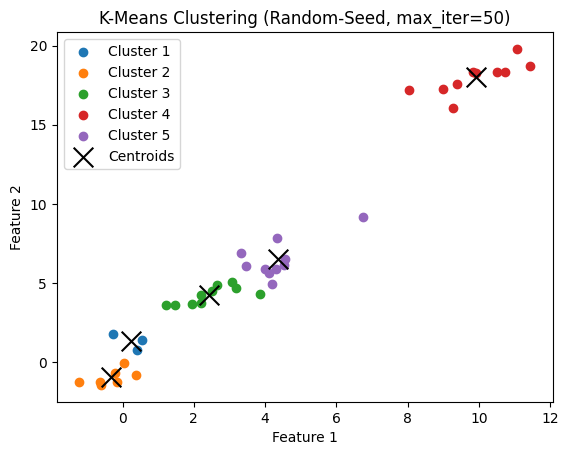

In [411]:
# Define input and apply k-means to report silhouette score:
init_method = 'random_seed'
max_iter = 50
k = 5
threshold = 1e-9

clusters, cluster_centers = k_means(cluster_train_data, init_method, max_iter, k, threshold)

silhouette_score = calculate_silhouette_score(clusters, cluster_centers)
print("Silhouette Score: ", silhouette_score, "\n")  # Note: changes slightly every run

# Graph results to visualize accuracy (graphing help reference: https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html):
for cluster_index, cluster in enumerate(clusters):
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {cluster_index+1}')

# Plot the cluster centers:
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', s=200, marker='x', label='Centroids')

# Format plot:
plt.title('K-Means Clustering (Random-Seed, max_iter=50)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Part 3: Bonus


---

In [412]:
# Define input and run the model:
init_method = 'random_split'
max_iter = 100
threshold = 1e-4

k_values = [2,3,4,5]
test_silhouette_scores = {}

for k in k_values:
  clusters, cluster_centers = k_means(cluster_train_data, init_method, max_iter, k, threshold)
  test_silhouette_scores[k] = calculate_silhouette_score(clusters, cluster_centers)
  print(f"Silhouette Score for k={k}: {test_silhouette_scores[k]}")

best_k = max(test_silhouette_scores, key=test_silhouette_scores.get)
print("\nThe best value of k is:", best_k)

Silhouette Score for k=2: 0.7686441976362192
Silhouette Score for k=3: 0.7180062652612687
Silhouette Score for k=4: 0.6179881838434761
Silhouette Score for k=5: 0.6302119208847985

The best value of k is: 2
